In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import librosa
import os
import tensorflow as tf
##if you need any imports you can do that here.
from zipfile import ZipFile
from sklearn.model_selection import StratifiedShuffleSplit
from glob import glob

from sklearn.model_selection import train_test_split
from timeit import default_timer as timer
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model,to_categorical

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Activation, MaxPooling1D, Dropout, BatchNormalization
from tensorflow.keras.utils import plot_model,to_categorical

<pre><font size=6>Analysing Wave file</font></pre>

Elements contained in the filenames:

Patient number (101,102,...,226)

Recording index

Chest location (Trachea (Tc), {Anterior (A), Posterior (P), Lateral (L)}{left (l), right (r)})
Acquisition mode (sequential/single channel (sc), simultaneous/multichannel (mc))
Recording equipment (AKG C417L Microphone, 3M Littmann Classic II SE Stethoscope, 3M Litmmann 3200 Electronic Stethoscope, WelchAllyn Meditron Master Elite Electronic Stethoscope)

In [3]:
audio_path = '/kaggle/input/respiratory-sound-database/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files'
text_files = glob(audio_path + '/*.txt')

audio_files = glob(audio_path + '/*.wav')
wav_files = sorted([f.replace(audio_path+'/','') for f in audio_files if f.endswith('.wav')])  # Gets wav files 


Retireve essential .wav files

In [4]:
print()
print("Files path audio_files")
print(audio_path)
print()
print("WAVE file")
print(wav_files[0:5])


Files path audio_files
/kaggle/input/respiratory-sound-database/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files

WAVE file
['101_1b1_Al_sc_Meditron.wav', '101_1b1_Pr_sc_Meditron.wav', '102_1b1_Ar_sc_Meditron.wav', '103_2b2_Ar_mc_LittC2SE.wav', '104_1b1_Al_sc_Litt3200.wav']


In [5]:
to_hot_one = {"COPD":0, "Healthy":1, "URTI":2, "Bronchiectasis":3, "Pneumonia":4, "Bronchiolitis":5, "Asthma":6, "LRTI":7}
labels1 = []
diagnosis = pd.read_csv('../input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv')

diag_dict = { 101 : "URTI"}  
#diagnosis_list = []
  
for index , row in diagnosis.iterrows():
    diag_dict[row[0]] = row[1]
    
    
    

In [6]:
print("Diagnosis file")
print(diagnosis.head(3))
print()
print("File labels in diag_dict")
print(diag_dict)


Diagnosis file
   101     URTI
0  102  Healthy
1  103   Asthma
2  104     COPD

File labels in diag_dict
{101: 'URTI', 102: 'Healthy', 103: 'Asthma', 104: 'COPD', 105: 'URTI', 106: 'COPD', 107: 'COPD', 108: 'LRTI', 109: 'COPD', 110: 'COPD', 111: 'Bronchiectasis', 112: 'COPD', 113: 'COPD', 114: 'COPD', 115: 'LRTI', 116: 'Bronchiectasis', 117: 'COPD', 118: 'COPD', 119: 'URTI', 120: 'COPD', 121: 'Healthy', 122: 'Pneumonia', 123: 'Healthy', 124: 'COPD', 125: 'Healthy', 126: 'Healthy', 127: 'Healthy', 128: 'COPD', 129: 'URTI', 130: 'COPD', 131: 'URTI', 132: 'COPD', 133: 'COPD', 134: 'COPD', 135: 'Pneumonia', 136: 'Healthy', 137: 'URTI', 138: 'COPD', 139: 'COPD', 140: 'Pneumonia', 141: 'COPD', 142: 'COPD', 143: 'Healthy', 144: 'Healthy', 145: 'COPD', 146: 'COPD', 147: 'COPD', 148: 'URTI', 149: 'Bronchiolitis', 150: 'URTI', 151: 'COPD', 152: 'Healthy', 153: 'Healthy', 154: 'COPD', 155: 'COPD', 156: 'COPD', 157: 'COPD', 158: 'COPD', 159: 'Healthy', 160: 'COPD', 161: 'Bronchiolitis', 162: 'COPD

# Putting all the file information in one place

In [7]:
class Diagnosis():
  def __init__ (self, id, diagnosis, image_path):
    self.id = id
    self.diagnosis = diagnosis 
    self.image_path = image_path  
c = 0

diagnosis_list = []
for f in wav_files:
    diagnosis_list.append(Diagnosis(c, diag_dict[int(f[:3])], audio_path+"/"+f))  
    c+=1 

In [8]:
print(diagnosis_list[0])
print("")
print(diagnosis_list[0].id)
print(diagnosis_list[0].diagnosis)
print(diagnosis_list[0].image_path)


0
URTI
/kaggle/input/respiratory-sound-database/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.wav


In [9]:
def audio_features(filename): 
  sound, sample_rate = librosa.load(filename)
  stft = np.abs(librosa.stft(sound))  
  #a = librosa.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=40)
  mfccs = np.mean(librosa.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=40),axis=1)
  chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate),axis=1)
  mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)
  contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate),axis=1)
  tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(sound), sr=sample_rate),axis=1)
    

  concat = np.concatenate((mfccs,chroma,mel,contrast,tonnetz))

  return concat

In [ ]:
to_hot_one = {"COPD":0, "Healthy":1, "URTI":2, "Bronchiectasis":3, "Pneumonia":4, "Bronchiolitis":5, "Asthma":6, "LRTI":7}
count = 0
labels = []
images = []
for f in diagnosis_list:
    labels.append(to_hot_one[f.diagnosis]) 
    images.append(audio_features(f.image_path))
    #if(count ==120):
        #break
    print(count)
#/kaggle/input/respiratory-sound-database/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/122_2b3_Ar_mc_LittC2SE.wav    
#/kaggle/input/respiratory-sound-database/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files101_1b1_Al_sc_Meditron.wav    
    count+=1

# **BUILDING MACHINE LEARNING MODEL - CNN AND LSTM**

In [36]:
def preprocessing(labels, images):    

  
  images = np.delete(images, np.where((labels == 7) | (labels == 6))[0], axis=0) 
  labels = np.delete(labels, np.where((labels == 7) | (labels == 6))[0], axis=0) 
   

  # Split data
  X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=20)
    

 
  # Hot one encode the labels
  y_train = to_categorical(y_train)
  y_test = to_categorical(y_test)  
  #print(X_train.shape)
  #print(X_train)
  #print(y_train)

  # Format new data

 

  return X_train, X_test, y_train, y_test

In [37]:
X_train, X_test, y_train, y_test = preprocessing(labels, images)


In [39]:
y_train.shape

(644, 8)

In [40]:
y_train = np.reshape(y_train, (y_train.shape[0], 8))
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_test = np.reshape(y_test, (y_test.shape[0], 8))
X_test = np.reshape(X_test, (X_test.shape[0], X_train.shape[1],  1))

# Convolutional neural Network



In [41]:
model = Sequential()
model.add(Conv1D(32, kernel_size=3, padding='same', input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))    
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=3,padding='same', input_shape=(40, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))    
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))   
model.add(Dense(8, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [42]:
# Display model architecture summary 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 193, 32)           128       
_________________________________________________________________
batch_normalization (BatchNo (None, 193, 32)           128       
_________________________________________________________________
activation (Activation)      (None, 193, 32)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 96, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 96, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 64)            6208      
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 64)            2

Epoch 1/60
33/33 [==============================] - 0s 8ms/step - loss: 0.4149 - accuracy: 0.8727 - val_loss: 0.5279 - val_accuracy: 0.8370
Epoch 2/60
33/33 [==============================] - 0s 6ms/step - loss: 0.3954 - accuracy: 0.8758 - val_loss: 0.3445 - val_accuracy: 0.8732
Epoch 3/60
33/33 [==============================] - 0s 6ms/step - loss: 0.3503 - accuracy: 0.8820 - val_loss: 0.3750 - val_accuracy: 0.8659
Epoch 4/60
33/33 [==============================] - 0s 6ms/step - loss: 0.3472 - accuracy: 0.8913 - val_loss: 0.3592 - val_accuracy: 0.8877
Epoch 5/60
33/33 [==============================] - 0s 6ms/step - loss: 0.3045 - accuracy: 0.8882 - val_loss: 0.3813 - val_accuracy: 0.8913
Epoch 6/60
33/33 [==============================] - 0s 7ms/step - loss: 0.3158 - accuracy: 0.8804 - val_loss: 0.3924 - val_accuracy: 0.8804
Epoch 7/60
33/33 [==============================] - 0s 10ms/step - loss: 0.3592 - accuracy: 0.8711 - val_loss: 0.3514 - val_accuracy: 0.8877
Epoch 8/60
33/33 [=

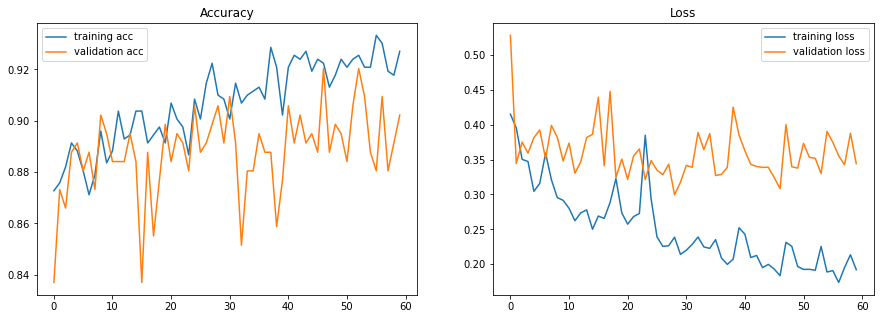

In [44]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=60, batch_size=20, verbose=1)

score = model.evaluate(X_test, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score[1]/1))
print("Loss: %.4f\n" % score[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label = 'training acc')
plt.plot(history.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()

In [46]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
#X_train, y_train

In [47]:
from keras.layers import Dropout

# Initialising the RNN
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and Dropout layer
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and Dropout layer
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and and Dropout layer
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
# For Full connection layer we use dense
# As the output is 1D so we use unit=1
#model.add(Dense(units = 1))


model.add(Flatten())

model.add(Dense(512, activation='relu'))   
model.add(Dense(8, activation='softmax'))

In [48]:
# Display model architecture summary 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 193, 50)           10400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 193, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 193, 50)           20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 193, 50)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 193, 50)           20200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 193, 50)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)               

In [49]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [50]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=20, verbose=1)


Epoch 1/50
33/33 [==============================] - 7s 72ms/step - loss: 1.3262 - accuracy: 0.7777 - val_loss: 0.6597 - val_accuracy: 0.8514
Epoch 2/50
33/33 [==============================] - 1s 36ms/step - loss: 0.6196 - accuracy: 0.8696 - val_loss: 0.6755 - val_accuracy: 0.8514
Epoch 3/50
33/33 [==============================] - 1s 38ms/step - loss: 0.7098 - accuracy: 0.8533 - val_loss: 0.6626 - val_accuracy: 0.8514
Epoch 4/50
33/33 [==============================] - 1s 40ms/step - loss: 0.6766 - accuracy: 0.8524 - val_loss: 0.6626 - val_accuracy: 0.8514
Epoch 5/50
33/33 [==============================] - 1s 39ms/step - loss: 0.6803 - accuracy: 0.8582 - val_loss: 0.6629 - val_accuracy: 0.8514
Epoch 6/50
33/33 [==============================] - 1s 37ms/step - loss: 0.5939 - accuracy: 0.8746 - val_loss: 0.6635 - val_accuracy: 0.8514
Epoch 7/50
33/33 [==============================] - 1s 37ms/step - loss: 0.6507 - accuracy: 0.8574 - val_loss: 0.6565 - val_accuracy: 0.8514
Epoch 8/50
33

Accuracy: 85%
Loss: 0.6562



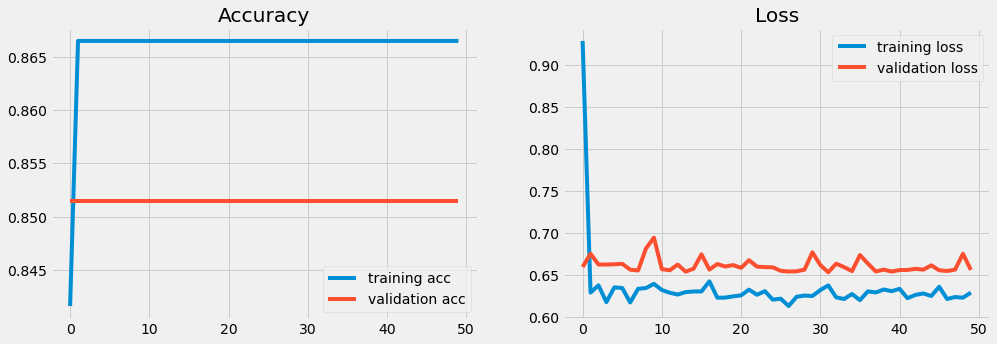

In [51]:

score = model.evaluate(X_test, y_test, batch_size=20, verbose=0)
print('Accuracy: {0:.0%}'.format(score[1]/1))
print("Loss: %.4f\n" % score[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label = 'training acc')
plt.plot(history.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()

# **ANALYSIS OF DATA**

In [69]:
# heart it
import IPython.display as ipd
ipd.Audio("/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/103_2b2_Ar_mc_LittC2SE.wav") 
#162- COPD
#


In [70]:
# Load use wave
import wave
loc = "/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/162_1b2_Ar_mc_AKGC417L.wav"

wav = wave.open(loc )
print("Sampling (frame) rate = ", wav.getframerate())
print("Total samples (frames) = ", wav.getnframes())
print("Duration = ", wav.getnframes()/wav.getframerate())

Sampling (frame) rate =  44100
Total samples (frames) =  882000
Duration =  20.0


[ 0.          0.          0.         ... -0.35665947 -0.3455619
 -0.37337008]
22050
20.0


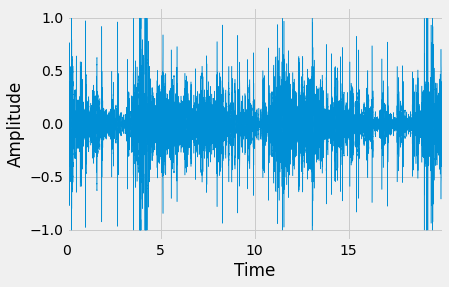

In [71]:
#loc = '/Users/manu/Downloads/recordings/'+'7_yweweler_45.wav'
import librosa, librosa.display
import matplotlib.pyplot as plt
import os
import tensorflow as tf

signal, sample_rate = librosa.load(loc, sr=22050)

print(signal)
print(sample_rate)
print(librosa.get_duration(y=signal, sr=sample_rate))
librosa.display.waveplot(signal, sr = sample_rate)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

[117.45383523]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  from ipykernel import kernelapp as app


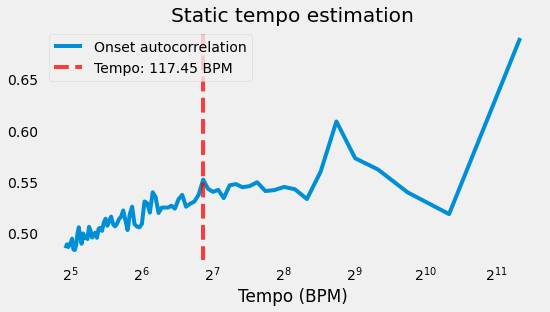

In [72]:
#librosa.beat.tempo(y=signal, sr=22050, onset_envelope=None, hop_length=512, start_bpm=120, std_bpm=1.0, ac_size=8.0, max_tempo=320.0)
import librosa as lr, librosa.display
y = signal
sr = sample_rate
onset_env = lr.onset.onset_strength(y, sr=sr)
tempo = lr.beat.tempo(onset_envelope=onset_env, sr=sr)
print(tempo)
tempo = np.asscalar(tempo)
# Compute 2-second windowed autocorrelation
hop_length = 512
ac = lr.autocorrelate(onset_env, 2 * sr // hop_length)
freqs = lr.tempo_frequencies(len(ac), sr=sr,hop_length=hop_length)
# Plot on a BPM axis.  We skip the first (0-lag) bin.
plt.figure(figsize=(8,4))
plt.semilogx(freqs[1:], lr.util.normalize(ac)[1:],label='Onset autocorrelation', basex=2)
plt.axvline(tempo, 0, 1, color='r', alpha=0.75, linestyle='--',label='Tempo: {:.2f} BPM'.format(tempo))
plt.xlabel('Tempo (BPM)')
plt.grid()
plt.title('Static tempo estimation')
plt.legend(frameon=True)
plt.axis('tight')
plt.show()



[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
///
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


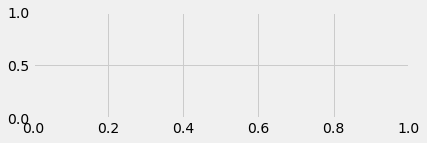

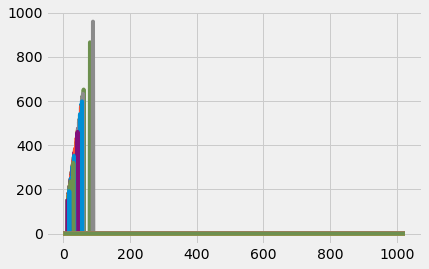

In [73]:
pitches, magnitudes = lr.piptrack(y=y, sr=sr)
print(pitches)
print('///')
print(magnitudes)
plt.subplot(212)
plt.show()
plt.plot(pitches)
plt.show()

/opt/conda/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/opt/conda/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


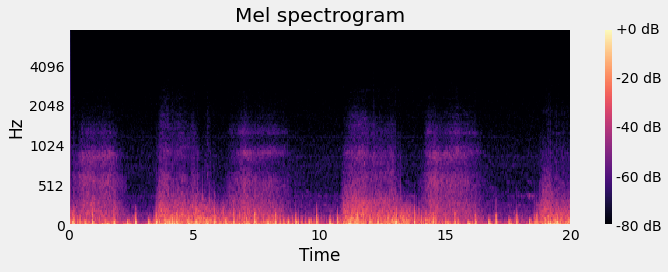

In [74]:
lr.feature.melspectrogram(y=y, sr=sr)

D = np.abs(lr.stft(y))**2
S = lr.feature.melspectrogram(S=D)
S = lr.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
plt.figure(figsize=(10, 4))
lr.display.specshow(lr.power_to_db(S,ref=np.max),y_axis='mel', fmax=8000,x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()
plt.show()

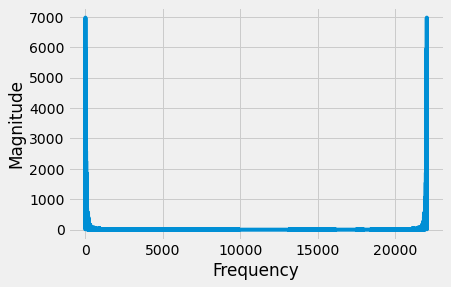

In [75]:
#fft

fft = np.fft.fft(signal)
magnitude = np.abs(fft)
frequency = np.linspace(0, sample_rate, len(magnitude))
plt.plot(frequency, magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

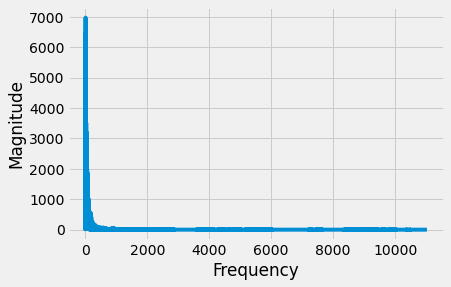

In [76]:
#left_fft
left_frequency = frequency[:int(len(frequency)/2)]
left_magnitude = magnitude[:int(len(magnitude)/2)]

plt.plot(left_frequency, left_magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

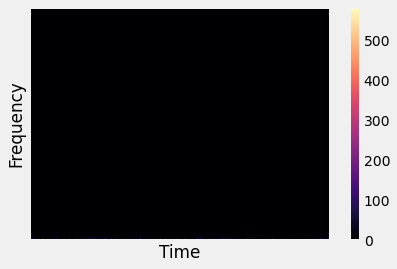

In [77]:
#STFT - spectogram

n_fft = 2048
hop_length = 512

stft = librosa.core.stft(signal, n_fft = n_fft, hop_length = hop_length)
spectogram = np.abs(stft)

librosa.display.specshow(spectogram, sr = sample_rate, hop_length = hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

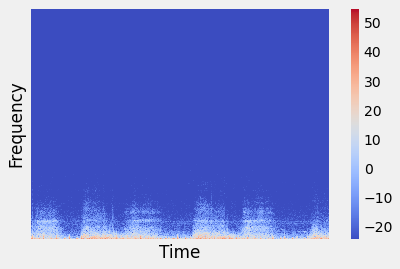

In [78]:
#STFT - log spectogram
n_fft = 2048
hop_length = 512

stft = librosa.core.stft(signal, n_fft = n_fft, hop_length = hop_length)
spectogram = np.abs(stft)
log_spectogram = librosa.amplitude_to_db(spectogram)

librosa.display.specshow(log_spectogram, sr = sample_rate, hop_length = hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

/opt/conda/lib/python3.7/site-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


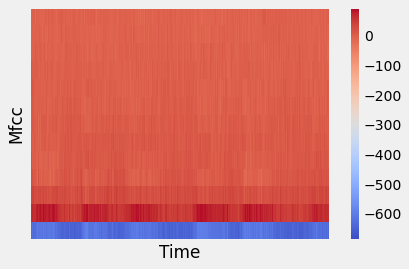

In [79]:
#MFCC

n_fft = 200
hop_length = 50

mfcc = librosa.feature.mfcc(signal, n_fft = n_fft, hop_length = hop_length, n_mfcc = 13)

librosa.display.specshow(mfcc, sr = sample_rate, hop_length = hop_length)
plt.xlabel("Time")
plt.ylabel("Mfcc")
plt.colorbar()
plt.show()